<h1><span style='background:#FFADAD'> Factors Influencing Customer Purchase Frequency </span></h1>


FEEDBACK:
<br>Mechanics
<br><span style='color:green'>- did not check for NA values</span>
<br><span style='color:green'>- Do not print out the entire dataframe, use functions like head() to make your report cleaner </span>
- Your html rendered in a weird format, so try to see if you can fix that!

Reasoning: 
- lack of summary table, including more than one since looking at count won’t really help with exploratory data analysis.I would suggest finding the mean/sd of each variable based on the class so that you’ll be able to see and point out the difference. 
- lack of figures. You mentioned in your proposal that you will be making plots for the other variables, but you are expected to do it here since it will help you check whether or not a variable will be relevant to your final model. 
- The plot you made looks like it’s only looking at the count and not the distribution of the variable. A plot that might be useful is a boxplot. This allows you to see the distribution and centers in a more detailed manner.
- The whole point of EDA is to analyze which variables will not be relevant to our model, thus can be removed. For the purpose of the final proposal, I would suggest just using 2-3 variables for your final model. But make sure that you have proper data/reasoning as to why you are selecting these variables.

TO DO:
1. reformulate research question to be more predictive (e.g. which purchase frequency category would a new customer be in based on a model that uses income, age and gender as predictors)
2. address NA's in tidying data (even though we know there aren't any)
3. ensure html format is readable for final submission
4. 

<h2><span style='background:#FFD6A5'>Introduction:</span></h2>

<span style='color:#FE81BF'>
Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your report
Clearly state the question you tried to answer with your project
Identify and describe the dataset that was used to answer the question</span>

<div style="text-align: justify">
Understanding customer behavior, particularly consumer purchase frequency, is crucial for businesses aiming to achieve success in competitive markets. Purchase frequency refers to the number of times a customer makes a purchase within a specific time period, such as a week, month, or year. By unraveling the factors that influence purchase frequency among different customer demographics, companies can gain valuable insights to shape their marketing strategies effectively and potentially enhance overall profitability. This project aims to explore the key factors that impact a customer's purchase frequency, specifically focusing on the variables of age, gender, education, and income. <br><br>To address this research question, we will utilize the Customer Spending Dataset obtained from Kaggle. The  dataset can be found on Kaggle using the link provided. This dataset includes the variables age, gender, education level, income, country of residence, purchase frequency, and spending amounts. Purchase frequency is quantified as the number of purchases made by a customer within a time period, ranging from 0.1 (least often) to 1.0 (most often)
 <br><br>The dataset consists of an equal proportion of male and female customers ages 18 and 65, with incomes ranging from \$20,000 to \$99,800. We will narrow down the dataset to use age, gender, education and income as the predictors for consumers' purchase frequency. By analyzing the relationships between age, gender, income, and purchase frequency, we aim to identify the significant predictors of purchase frequency and provide valuable insights for businesses seeking to optimize their marketing strategies.
</div>

 
> Dataset Link: https://www.kaggle.com/datasets/goyaladi/customer-spending-dataset 


<h2><span style='background:#FDFFB6'>Preliminary Exploratory Data Analysis:</span></h2>

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(broom)
library(ggplot2)

set.seed(3456) 
data <- read_csv("https://raw.githubusercontent.com/Kaylan-W/Dsci_project/main/data/customer_data.csv")
#data

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:
# The data will be tidied by removing unused columns and creating categorical variables
# from the columns purchase_frequency, gender, education to aid with later classification.
data_downsized<- select(data, -name, -country)

# Remove rows with NAs
data_downsized <- na.omit(data_downsized)

# Create a categorical variable for purchase frequency
breakpoints <- c(0, 0.25, 0.5, 0.75, 1)
labels <- c("Very Low", "Low", "High", "Very High")
tidydata<- data_downsized %>% mutate(pf_categories = cut(data_downsized$purchase_frequency, 
                                                    breakpoints, labels = labels, include.lowest = TRUE))|>
select(-gender, -education)  #removing non numeric data 

# Before any further processing, the original dataset will be split into training and testing datasets.
# 75% of the data will be put into the training set. 
data_split <- initial_split(tidydata, prop = 0.75, strata = pf_categories)  
train_split <- training(data_split)   
test_split <- testing(data_split)
head(train_split)

#Create Summary Table 
summary_table <- train_split %>%
  group_by(pf_categories) %>%
  summarize(count = n(),
            age_mean = mean(age),
            age_sd = sd(age),
            income_mean = mean(income),
            income_sd = sd(income),
            spending_mean = mean(spending),
            spending_sd = sd(spending)) %>%
  arrange(desc(count))

summary_table

age,income,purchase_frequency,spending,pf_categories
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
34,32225,0.7,6727.875,High
19,48896,0.6,5666.880,High
56,31997,0.6,12959.910,High
22,59460,0.6,4783.800,High
48,66812,0.7,14238.420,High
35,83154,0.6,9094.620,High


pf_categories,count,age_mean,age_sd,income_mean,income_sd,spending_mean,spending_sd
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Low,221,41.01357,13.46696,58786.88,22611.21,6983.932,2257.577
Very High,216,41.91204,13.42461,60063.37,23970.54,15531.407,3706.826
High,171,43.00585,13.61897,60311.62,24099.13,11204.028,2852.182
Very Low,141,40.87234,13.58931,58583.35,23945.67,2516.168,1018.822


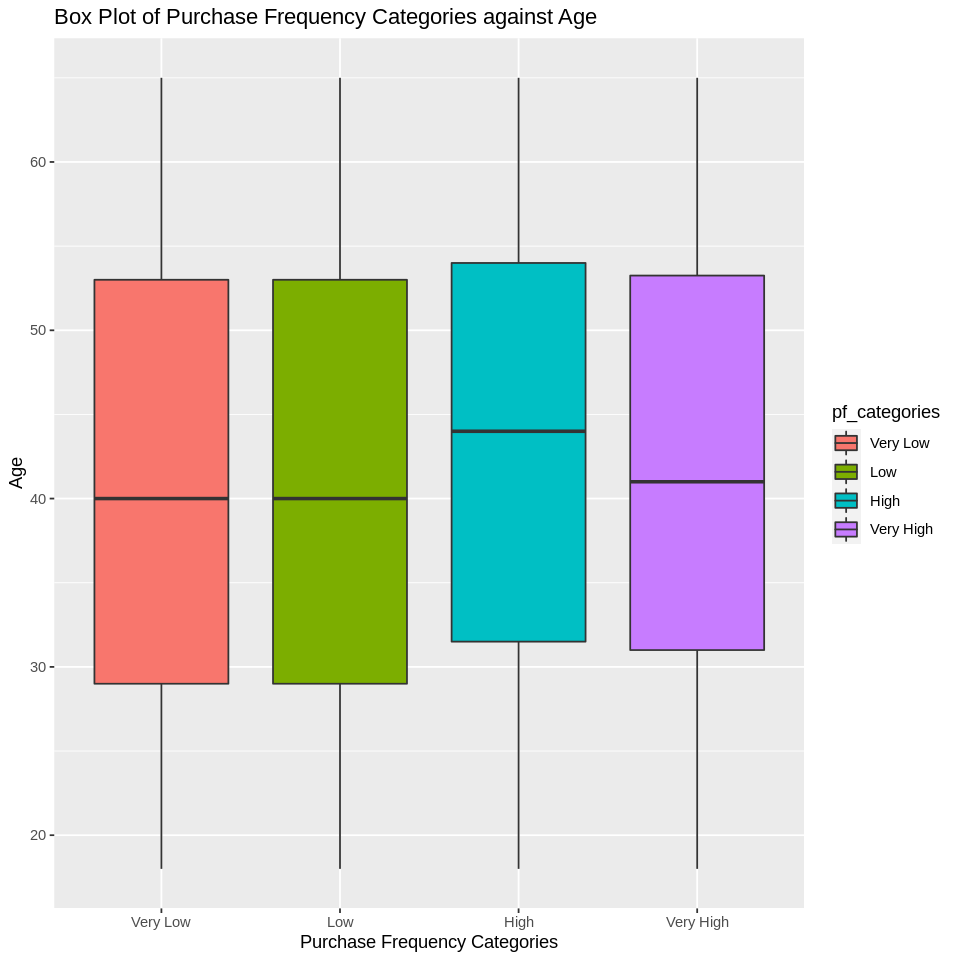

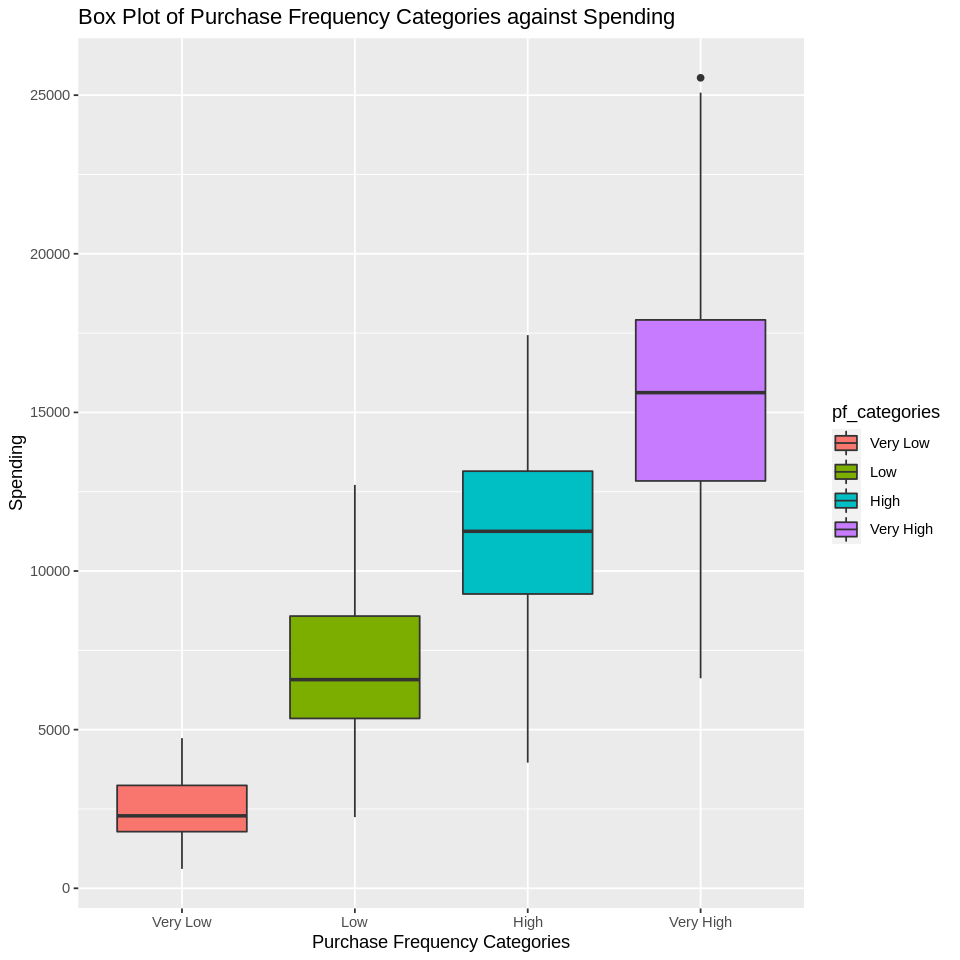

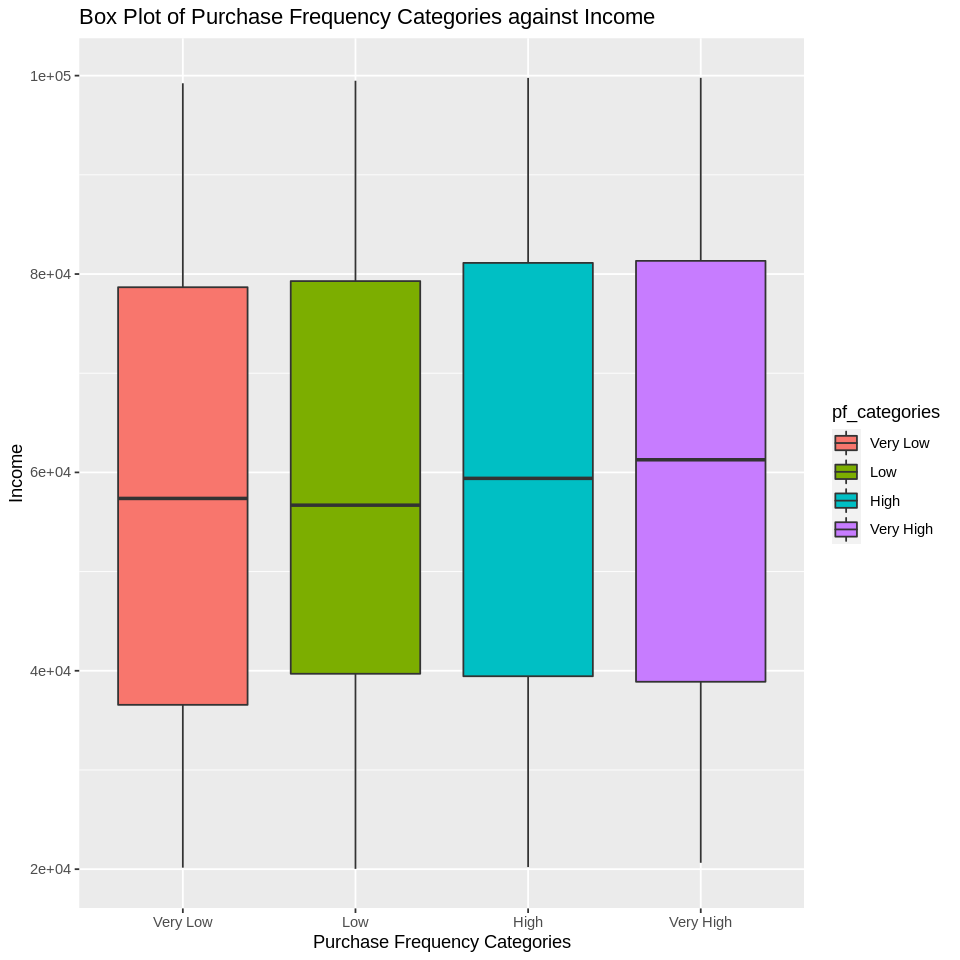

In [5]:
options(repr.plot.width = 8, repr.plot.height = 8)

ageplot<- ggplot(train_split, aes(x = pf_categories, y = age, fill = pf_categories)) +
  geom_boxplot() +
  xlab('Purchase Frequency Categories') +
  ylab('Age') +
  ggtitle('Box Plot of Purchase Frequency Categories against Age')

ageplot


spendingplot<- ggplot(train_split, aes(x = pf_categories, y = spending, fill = pf_categories)) +
  geom_boxplot() +
  xlab('Purchase Frequency Categories') +
  ylab('Spending') +
  ggtitle('Box Plot of Purchase Frequency Categories against Spending')

spendingplot


incomeplot<- ggplot(train_split, aes(x = pf_categories, y = income, fill = pf_categories)) +
  geom_boxplot() +
  xlab('Purchase Frequency Categories') +
  ylab('Income') +
  ggtitle('Box Plot of Purchase Frequency Categories against Income')

incomeplot

ANALYSIS OF VISUALIZATIONS TO CHOOSE THE APPROPRIATE VARIABLES FOR OUR MODEL:

Using ggpairs(), we see that there is the biggest correlations between the variables 

As part of our analysis of the data we will be creating plots graphs with each of the predictior variables(age, gender and income) against purchase frequency (percentages) to visualize how these variables affect purchase frechency. The plot above the purchase frequency categories were further divided into gender categories. The number of customers in each of these categories were plotted. Here, we can compare the effects of gender within each of the categories. We see that there are few men in the very low purchase frequency range then women while there are more men in the low purchase frequency range.


<h2><span style='background:#CAFFBF'>Methods & Results:</span></h2>

<span style='color:#FE81BF'> Describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis. Your report should include code which:
<br>1. loads data from the original source on the web 
<br>2. wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
<br>3. performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
<br>4. creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
<br>5. performs the data analysis
<br>6. creates a visualization of the analysis 
<br>7. note: all tables and figure should have a figure/table number and a legend </span>

We are going to explore relationship between the variables age, gender, and income and a customer's purchase frequency. 
To do this, we will:
1. Represent purchase frequency as categories instead of numerical values. The categories will be:
    - Very low (0.00-0.25)
    - Low (0.25-0.50) 
    - High (0.50-0.75)   
    - Very high (0.75 - 1.00)
2. Create three separate k-nn classification models, each using only one variable as a predictor. 
3. Tune the number of neighbours used in order to obtain the optimal parameters for each of the three models.
4. Calculate the accuracy of each model's predictions. 
5. Use visualizations to compare the accuracy of the three models. 
6. Determine which variable has the greatest influence on purchase frequency. 
 
For the visualization aspect of our project we will create different plots, each graphing one of the predictor variables for our purchase frequency models (age, gender and income). An example of the plots we will create is given above. We plotted the number of customers within each gender and purchase frequency category. We will construct similar bar charts for age and income. While gender is easily separated into categories, age and income are continuous variables and we will need to make ranges of each of these to plot with purchase frequency categories in bars. Comparing these three plots will give us a visual idea of how each of the predictor variables independently affect purchase frequency.

<h2><span style='background:#9BF6FF'>Discussion:</span></h2>

<span style='color:#FE81BF'>
<br>1. summarize what you found
<br>2. discuss whether this is what you expected to find.
<br>4. discuss what impact could such findings have.
<br>5. discuss what future questions could this lead to. </span>



* We expect to find that people with higher income and age have a higher purchase frequency. 
* We also expect to find gender will not have an impact on purchase frequency.
* These findings could impact how stores will go about marketing their products to people of different economic class' and demographics. The outcome of this data analysis could provide information on which customers a company should advertise towards. 
* Further questions could be asked to analyze which products these individuals with different demographical characteristcs (ex. higher income) prefer and how the advertising affects their purchase frequency.

<h2><span style='background:#CCB7E5'>References:</span></h2>

<span style='color:#FE81BF'>
At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well. </span>

Kholis, N., &amp; Ma’rifa, A. (2021, November 19). The influence of price and income on purchase decisions among fast-food consumers: The mediating effect of lifestyle. Go to start page! http://repository.uinsa.ac.id/id/eprint/1904/ 

Lennon, S. J., Sanik, M. M., &amp; Stanforth, N. F. (2003). Motivations for television shopping: Clothing purchase frequency and personal characteristics. Clothing and Textiles Research Journal, 21(2), 63–74. https://doi.org/10.1177/0887302x0302100202 

Özdemir, E., &amp; Akçay, G. (2019). The effect of gender identity on consumers&nbsp; impulse buying behavior and the moderating role of Biological Sex. Business and Economics Research Journal, 10(5). https://doi.org/10.20409/berj.2019.218 

